In [1]:
import os

In [4]:
eletricity_files = os.listdir('dataset/eletricity/')
eletricity_files

['2020年度每日尖峰備轉容量率.csv', '2021年度每日尖峰備轉容量率.csv']

In [5]:
weather_files = os.listdir('dataset/weather/')
weather_files

['weather_day.csv', 'weather_forcast.csv']

In [6]:
import pandas
import numpy as np

# Electicity Data

In [8]:
edf1 = pandas.read_csv(os.path.join('dataset/eletricity', eletricity_files[0]))

edf1

,日期,備轉容量(萬瓩),備轉容量率(%)
0,2020/01/01,279.0,11.01
1,2020/01/02,308.0,10.91
2,2020/01/03,338.3,11.96
3,2020/01/04,363.6,14.21
4,2020/01/05,269.5,10.88
...,...,...,...
345,2020/12/11,312.9,10.46
346,2020/12/12,328.2,12.31
347,2020/12/13,283.0,11.12
348,2020/12/14,302.1,10.20


In [9]:
edf2 = pandas.read_csv(os.path.join('dataset/eletricity', eletricity_files[1]))

edf2

,日期,備轉容量(萬瓩),備轉容量率(%)
0,2021/01/01,276.7,10.76
1,2021/01/02,293.6,11.52
2,2021/01/03,303.7,11.92
3,2021/01/04,303.2,10.20
4,2021/01/05,306.7,10.21
...,...,...,...
75,2021/03/17,318.3,10.36
76,2021/03/18,321.4,10.46
77,2021/03/19,313.7,10.16
78,2021/03/20,283.9,10.23


In [63]:
eletricities = np.concatenate([edf1['備轉容量(萬瓩)']*10, edf2['備轉容量(萬瓩)']*10])
len(eletricities[-357:])

357

# Weather Data

In [10]:
wdf1 = pandas.read_csv(os.path.join('dataset/weather', weather_files[0]))

wdf1

,Unnamed: 0,日期,locationName,當日最高溫度(°C),當日最低溫度(°C),當日平均溫度(°C)
0,0,2020-03-18,"BANQIAO,板橋",24.1,17.0,20.3
1,1,2020-03-19,"BANQIAO,板橋",21.9,18.3,19.7
2,2,2020-03-20,"BANQIAO,板橋",25.2,18.7,21.7
3,3,2020-03-21,"BANQIAO,板橋",30.1,19.4,23.9
4,4,2020-03-22,"BANQIAO,板橋",32.0,20.8,25.2
...,...,...,...,...,...,...
10947,10947,2021-03-14,"TianZhong,田中",25.9,16.3,20.3
10948,10948,2021-03-15,"TianZhong,田中",26.4,16.7,21.1
10949,10949,2021-03-16,"TianZhong,田中",29.5,18.3,23.8
10950,10950,2021-03-17,"TianZhong,田中",28.4,19.4,23.1


In [35]:
# eletricity data only to 2020-12-15
dates2020 = sorted(list(set(wdf1['日期'])))[:273]
print(dates2020[0], dates2020[-1])

2020-03-18 2020-12-15


In [36]:
dates2021 = sorted(list(set(wdf1['日期'])))[289:]
print(dates2021[0], dates2021[-1])

2021-01-01 2021-03-18


In [40]:
avgs_temperature = []
for i in dates2020:
    avgs_temperature.append(np.average(wdf1[wdf1['日期'] == i]['當日平均溫度(°C)']))

for i in dates2021:
    avgs_temperature.append(np.average(wdf1[wdf1['日期'] == i]['當日平均溫度(°C)']))


In [42]:
len(avgs_temperature)

350

In [43]:
# read forcast weather data
wdf2 = pandas.read_csv(os.path.join('dataset/weather', weather_files[1]))

wdf2

,Unnamed: 0,北部地區,中部地區,南部地區
0,2021-03-20,12.5,14.0,16.0
1,2021-03-21,8.0,12.0,15.0
2,2021-03-22,4.5,9.0,11.0
3,2021-03-23,8.0,10.5,12.0
4,2021-03-24,9.5,11.5,13.0
5,2021-03-25,10.0,12.5,14.0
6,2021-03-26,11.0,12.5,14.5


In [49]:
for i in range(len(wdf2)):
    avgs_temperature.append(np.average(wdf2.iloc[i][1:4]))

In [50]:
len(avgs_temperature)

357

# dataset

In [59]:
from sklearn.preprocessing import normalize
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset


In [145]:

class Dataset(BaseDataset):
    def __init__(
        self,
        train_data_electricity,
        train_data_weather,
    ):
        #prepare the training data and label
        self.train_label = np.array(train_data_electricity, dtype=np.float32)
        self.train_data_electricity = np.array(train_data_electricity,  dtype=np.float32)
        self.train_data_weather = np.array(train_data_weather,  dtype=np.float32)
    
    def __getitem__(self, i):
        x = np.concatenate([self.train_data_electricity[i:10+i],  self.train_data_weather[i:10+i]])
        y = self.train_label[10+i:17+i]
        
        return x, y
    
    def __len__(self):
        return len(self.train_data_electricity) - 16

In [146]:
dataset = Dataset(train_data_electricity=eletricities[-len(avgs_temperature):-30], train_data_weather=avgs_temperature[:-30])

In [147]:
len(dataset)

311

In [148]:
x,y = dataset[1]

In [149]:
print(len(x), len(y))

20 7


In [150]:
x,y = dataset[len(dataset)-1]

In [151]:
y

array([3024., 2911., 2645., 3002., 2824., 2907., 2885.], dtype=float32)

# Model

In [152]:
import torch
import torch.nn as nn

In [158]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel,self).__init__()
        
        self.fc0 = nn.Linear(20, 128)
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc = nn.Linear(128, 7)
        self.flatten = nn.Flatten()
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc0(x)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc(x)
        
        return x

In [159]:
linear = LinearModel()

In [160]:
x,y = dataset[0]
x = torch.tensor(x, dtype=torch.float).unsqueeze(dim=0)
y = torch.tensor(y, dtype=torch.float).unsqueeze(dim=0)

In [161]:
linear.cuda()

LinearModel(
  (fc0): Linear(in_features=20, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
)

In [162]:
linear(x.cuda())

tensor([[-73.3358, 101.7850, -20.8268,   9.3922,  17.2271, -37.2161, -41.4122]],
       device='cuda:0', grad_fn=<AddmmBackward>)

# Training

In [163]:
loss = torch.nn.MSELoss(reduction='mean')

In [164]:
linear = LinearModel()
linear.cuda()

LinearModel(
  (fc0): Linear(in_features=20, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
)

In [165]:
optimizer = torch.optim.Adam([
    dict(params=linear.parameters(), lr=4e-4),
])

In [166]:
dataset = Dataset(train_data_electricity=eletricities[-len(avgs_temperature):-30], train_data_weather=avgs_temperature[:-30])

In [167]:
from tqdm import tqdm 

In [168]:
from torch.utils.data import DataLoader


train_loaders = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=8)

In [171]:
# train model for N epochs
max_valid_score = 0
EPOCH = 100
for epoch in range(EPOCH):

    torch.cuda.empty_cache()

    total_loss = 0
    for x, y in train_loaders:
        optimizer.zero_grad()     #optimizer gradient to zero

        # Get data
#         x, y = dataset[i]
        x = x.float().cuda()
        y = y.float().cuda()
        
        # Train 

        ## 1. forward propagationreal_labels
        ## -----------------------

        pred = linear(x)

        ## 2. loss calculation
        ## -----------------------
        _loss = loss(pred, y)
        
        # track loss
        total_loss += _loss.item()

        ## 3. backward propagation
        ## -----------------------
        _loss.backward()     


        ## 4. weight optimization
        ## -----------------------        
        optimizer.step()


#     if epoch %100 == 0:
    print("Epoch:", epoch, "Training Loss: {}".format(total_loss) )
        
    total_loss = 0



Epoch: 0 Training Loss: 1169604.82421875
Epoch: 1 Training Loss: 1168513.509765625
Epoch: 2 Training Loss: 1167562.662109375
Epoch: 3 Training Loss: 1166563.779296875
Epoch: 4 Training Loss: 1165458.1484375
Epoch: 5 Training Loss: 1164454.646484375
Epoch: 6 Training Loss: 1163617.271484375
Epoch: 7 Training Loss: 1162810.853515625
Epoch: 8 Training Loss: 1162061.439453125
Epoch: 9 Training Loss: 1161267.658203125
Epoch: 10 Training Loss: 1160455.908203125
Epoch: 11 Training Loss: 1159824.572265625
Epoch: 12 Training Loss: 1159187.06640625
Epoch: 13 Training Loss: 1158603.19921875
Epoch: 14 Training Loss: 1157744.583984375
Epoch: 15 Training Loss: 1157230.626953125
Epoch: 16 Training Loss: 1156709.26171875
Epoch: 17 Training Loss: 1156079.591796875
Epoch: 18 Training Loss: 1155536.05859375
Epoch: 19 Training Loss: 1154992.169921875
Epoch: 20 Training Loss: 1154465.349609375
Epoch: 21 Training Loss: 1153903.15234375
Epoch: 22 Training Loss: 1153349.498046875
Epoch: 23 Training Loss: 1152

# test

In [172]:
x, y = dataset[10]
x = torch.tensor(x, dtype=torch.float).unsqueeze(dim=0).cuda()
y = torch.tensor(y, dtype=torch.float).cuda()

In [173]:
pred = linear(x)
pred

tensor([[3842.8369, 3797.4343, 3799.5398, 3777.7070, 3741.4758, 3742.0996,
         3736.3337]], device='cuda:0', grad_fn=<AddmmBackward>)

In [174]:
y

tensor([3749., 4414., 4249., 4054., 4037., 3364., 3678.], device='cuda:0')

In [175]:
loss(pred, y)

/home/jeff/anaconda3/envs/work/lib/python3.6/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([1, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(128715.3594, device='cuda:0', grad_fn=<MseLossBackward>)

In [202]:
testset = Dataset(train_data_electricity=eletricities[-60:], train_data_weather=avgs_temperature[-60:])

In [203]:
test_loaders = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=1)

In [204]:
x_collect = []
pred_collect = []

In [205]:
# train model for N epochs
max_valid_score = 0

total_loss = 0
for x, y in tqdm(test_loaders):
    # Get data
#         x, y = dataset[i]
#     x = torch.tensor(x, dtype=torch.float).unsqueeze(dim=1).cuda()
#     y = torch.tensor(y, dtype=torch.float).cuda()
    x = x.float().cuda()
    y = y.float().cuda()

    # Train 

    ## 1. forward propagationreal_labels
    ## -----------------------

    pred = linear(x)

    ## 2. loss calculation
    ## -----------------------
    _loss = loss(pred, y)
    
    for j in pred.detach().cpu().numpy():
        pred_collect.append(j[0])
        # pred_collect.append(j)

    for j in x.detach().cpu().numpy():
        x_collect.append(j[6])


    # track loss
    total_loss += _loss.item()


#     if epoch %100 == 0:
print("Epoch:", epoch, "Training Loss: {}".format(total_loss) )
        



100%|██████████| 44/44 [00:00<00:00, 296.70it/s]Epoch: 99 Training Loss: 1249794.3388671875



In [206]:
import matplotlib.pyplot as plt

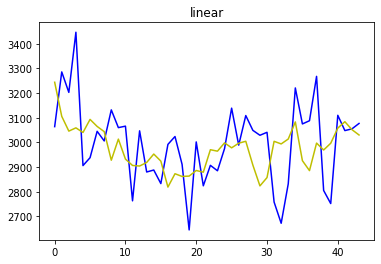

In [207]:
x = np.arange( len(pred_collect))
plt.plot(x, x_collect, 'b')
plt.plot(x, pred_collect, 'y')
plt.title('linear')
plt.show()